In [252]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from time import time
from inspyred import ec, benchmarks
from copy import deepcopy
from typing import List, Dict
from collections import Counter

In [253]:
class ACOWorkoutRoutine:
    def __init__(self, userLevel, equipment, requestMuscles, time, userID, exercises, num_ants, evaporation, alpha, beta, max_iterations):
        
        # Initial parameters (same as GA)
        self.userLevel = userLevel.lower()
        self.time = time  # hours

        self.length = time * 6  # max 6 exercises per hour
        self.equipment = equipment
        self.requestMuscles = requestMuscles
        self.userID = userID
        
        # ACO parameters
        self.num_ants = num_ants
        self.evaporation = evaporation  # Pheromone evaporation rate
        self.alpha = alpha  # Pheromone weight
        self.beta = beta   # Heuristic weight
        self.max_iterations = max_iterations
        self.pheromone = None
        
        # Difficulty mapping (same as GA)
        self.difficulty_map = {
            "beginner": 0, "novice": 1, "intermediate": 2,
            "advanced": 3, "expert": 4, "master": 5
        }

        # History
        self.pheromone_history = []
        self.trails_history = []
        self.best_fitness_history = []

        # Exercises
        self.exercises = exercises  # List of exercises
        self.exercises = self.clean_exercises(exercises)
        
    
    def clean_exercises(self, exercises):
        def clean_equipment(val):
            return str(val).strip().lower() if isinstance(val, str) else ''

        requested = {str(m).strip().lower() for m in self.requestMuscles}
        user_eq = {str(e).strip().lower() for e in self.equipment}
        has_gym = "gym" in user_eq

        valid_exercises = []
        for ex in exercises:
            if not ex:
                continue

            muscle = str(ex.get('TargetMuscleGroup', '')).strip().lower()
            primary = clean_equipment(ex.get('PrimaryEquipment'))
            secondary = clean_equipment(ex.get('SecondaryEquipment'))
            equipment_needed = {primary, secondary} - {''}

            # Skip if equipment is not available and user doesn't have gym access
            if not has_gym and not equipment_needed.issubset(user_eq):
                continue

            # Always include requested muscles
            if muscle in requested:
                valid_exercises.append(ex)
            else:
                if random.random() < 0.1:  # 10% chance for non-requested muscle
                    valid_exercises.append(ex)

        # Re-index the filtered exercises
        for idx, exercise in enumerate(valid_exercises):
            exercise['Index'] = idx

        """  
       print("[DEBUG] Final valid exercises:")
        for ex in valid_exercises:
            print(f"  Muscle: {ex['TargetMuscleGroup']}, Primary: {ex.get('PrimaryEquipment')}, Secondary: {ex.get('SecondaryEquipment')}")
            """
        return valid_exercises

    def initialize_pheromone(self):
        """Initialize the pheromone matrix with small values"""
        num_exercises = len(self.exercises)
        self.pheromone = np.ones((num_exercises, num_exercises)) * 0.1
    
    def evaluate(self, candidate):
        """Evaluation function (same as GA)"""
        routine = self.get_exercises(candidate)
        n = len(routine)

        y_penalties = self.repetition_penalties(candidate)
        y_factor = sum(y_penalties) / n
        muscles_factor = self.trained_muscles(routine)
        difficulty_factor = self.difficulty_score(routine)
        if not self.equipment == ["Gym"]:
            equipment_factor = self.used_equipment(routine)
        else:
            equipment_factor = 1  # si es gym, no penaliza por equipo

        
        value = 100 * y_factor * muscles_factor * difficulty_factor * equipment_factor
        
        if value < 100:
            bonus = self.calculate_bonus(routine)
            value = min(value + bonus, 100)
            
        return value
    
    def heuristic(self, prev_exercise, next_exercise):
        """Heuristic function that estimates the goodness of choosing next_exercise after prev_exercise"""
        # Penalty for close repetition
        repetition_penalty = 0.95 if prev_exercise == next_exercise else 1.0
        
        # Muscle group diversity
        muscle_diversity = 1.0
        if prev_exercise['TargetMuscleGroup'] != next_exercise['TargetMuscleGroup']:
            muscle_diversity = 1.1
            
        # Combine factors
        return repetition_penalty * muscle_diversity
    
    def select_next_exercise(self, current_exercise, remaining_exercises):
        """Select the next exercise based on pheromone and heuristic"""
        probabilities = []
        total = 0.0
        
        for ex in remaining_exercises:
            # Use exercise indices instead of names
            current_idx = current_exercise['Index']
            next_idx = ex['Index']
            
            pheromone = self.pheromone[current_idx][next_idx]
            heuristic = self.heuristic(current_exercise, ex)
            
            prob = (pheromone * self.alpha) * (heuristic * self.beta)
            probabilities.append((ex['Index'], prob))
            total += prob
        
        # Normalize probabilities
        if total > 0:
            probabilities = [(idx, prob/total) for idx, prob in probabilities]
            probabilities.sort(key=lambda x: x[1], reverse=True)
            
            # Roulette selection
            r = random.random()
            cumulative = 0.0
            for idx, prob in probabilities:
                cumulative += prob
                if r <= cumulative:
                    return idx
                    
        # If all probabilities are 0, select randomly
        return random.choice([ex['Index'] for ex in remaining_exercises])
    
    def construct_solution(self):
        """Construct a solution (routine) with an ant"""
        routine = []
        
        # Select a random initial exercise (by index)
        current = random.choice(self.exercises)
        routine.append(current['Index'])
        
        while len(routine) < self.length:
            next_idx = self.select_next_exercise(current, self.exercises)
            next_ex = next((ex for ex in self.exercises if ex['Index'] == next_idx), None)
            
            if next_ex is None:
                break
                
            routine.append(next_idx)
            current = next_ex
            
        return routine
    
    def update_pheromone(self, solutions):
        """Update the pheromone matrix"""
        # Evaporation
        self.pheromone *= (1 - self.evaporation)
        
        # Deposit pheromone for the best solutions
        for solution, fitness in solutions:
            for i in range(len(solution)-1):
                from_idx = solution[i]
                to_idx = solution[i+1]
                self.pheromone[from_idx][to_idx] += fitness / 100  # Normalized
        
        # History
        self.pheromone_history.append(self.pheromone.copy())
    
    def run(self):
        """Run the ACO algorithm"""
        self.initialize_pheromone()
        best_solution = None
        best_fitness = 0
        
        for iteration in range(self.max_iterations):
            solutions = []
            
            # Build solutions with all ants
            for _ in range(self.num_ants):
                solution = self.construct_solution()
                fitness = self.evaluate(solution)
                solutions.append((solution, fitness))
                
                if fitness > best_fitness:
                    best_fitness = fitness
                    best_solution = solution
            
            # History
            self.trails_history.append(solutions)
            self.best_fitness_history.append(best_fitness)

            # Update pheromone
            self.update_pheromone(solutions)
            
            print(f"Iteration {iteration}: Best fitness = {best_fitness}")
        
        return best_solution, best_fitness
    
    # Helper methods
    def get_exercises(self, candidate):
        return [self.exercises[i] for i in candidate]
    
    def repetition_penalties(self, candidate):
        penalties = [1] * len(candidate)
        for i, idx in enumerate(candidate):
            for j in range(i):
                if candidate[j] == idx:
                    dist = i - j
                    if dist <= 2:
                        penalties[i] = 0.2
                    elif dist <= 8:
                        penalties[i] = 0.4
                    else:
                        penalties[i] = 0.6
                    break
        return penalties
    
    def difficulty_score(self, routine):
        user_level = self.difficulty_map.get(self.userLevel, 0)
        scores = []
        for ex in routine:
            ex_level = self.difficulty_map.get(ex['DifficultyLevel'].strip().lower(), 0)
            diff = ex_level - user_level
            if diff > 0:
                score = max(0, 1 - 0.2 * diff)
            else:
                score = max(0, 1 - 0.1 * abs(diff))
            scores.append(score)
        return sum(scores) / len(scores)
    
    def used_equipment(self, routine):
        used = set()
        for ex in routine:
            if ex['PrimaryEquipment']:
                used.add(ex['PrimaryEquipment'])
            if ex['SecondaryEquipment']:
                used.add(ex['SecondaryEquipment'])
        if not self.equipment:
            return 1
        return min(0.1 * (len(used) / len(self.equipment)) + 0.9, 1)
    
    def trained_muscles(self, routine):
        target_muscles = [ex['TargetMuscleGroup'].strip().lower()
                        for ex in routine if ex and ex.get('TargetMuscleGroup')]
        muscle_counts = Counter(target_muscles)
        requested = [m.strip().lower() for m in self.requestMuscles]

        if not requested:
            return 1

        total_ex = len(routine)
        valid_ex = sum(1 for m in target_muscles if m in requested)
        required_ratio = 0.75
        if total_ex == 0 or valid_ex / total_ex < required_ratio:
            return 0

        covered = sum(1 for m in requested if muscle_counts[m] > 0)
        coverage = covered / len(requested)

        total_requested_ej = sum(muscle_counts[m] for m in requested)
        if total_requested_ej == 0:
            return 0
        ideal = total_requested_ej / len(requested)
        balance = 1 - sum(abs(muscle_counts[m] - ideal) for m in requested) / total_requested_ej


        factor = coverage * balance
        return max(min(factor, 1), 0)

    def calculate_bonus(self, routine):
        extra_bonus = 0
        seen_regions = set()
        for ex in routine:
            muscle = ex['TargetMuscleGroup']
            region = ex['BodyRegion']
            if muscle not in self.requestMuscles:
                if region in seen_regions:
                    extra_bonus += 0.1
                else:
                    extra_bonus += 0.05
                seen_regions.add(region)
        return extra_bonus

In [254]:
# getting the exercises form the CSV file
import pandas as pd

df = pd.read_csv('../assets/exercises.csv')

#Inicializar Problema
userLevel = "master"
equipment = ["kettlebell", "Clubbell", "Bodyweight"]
requestMuscles = ["Abdominals", "Quadriceps", "Chest", "Triceps", "Glutes"]
duration = 5
userID = 12345
exercises = df.to_dict(orient='records')
problem = ACOWorkoutRoutine(userLevel, equipment, requestMuscles, duration, userID, exercises, num_ants=100, evaporation=0.3, alpha=1.0, beta=2.0, max_iterations=30)
best = problem.run()[0]

Iteration 0: Best fitness = 24.31896551724137
Iteration 1: Best fitness = 27.332758620689663
Iteration 2: Best fitness = 27.332758620689663
Iteration 3: Best fitness = 27.332758620689663
Iteration 4: Best fitness = 30.48148148148148
Iteration 5: Best fitness = 30.48148148148148
Iteration 6: Best fitness = 30.48148148148148
Iteration 7: Best fitness = 30.48148148148148
Iteration 8: Best fitness = 30.48148148148148
Iteration 9: Best fitness = 30.48148148148148
Iteration 10: Best fitness = 30.48148148148148
Iteration 11: Best fitness = 33.333333333333336
Iteration 12: Best fitness = 33.333333333333336
Iteration 13: Best fitness = 35.733333333333334
Iteration 14: Best fitness = 35.733333333333334
Iteration 15: Best fitness = 40.777777777777786
Iteration 16: Best fitness = 40.777777777777786
Iteration 17: Best fitness = 40.777777777777786
Iteration 18: Best fitness = 40.777777777777786
Iteration 19: Best fitness = 40.834414814814814
Iteration 20: Best fitness = 40.834414814814814
Iteration 

In [255]:
final_routine = problem.get_exercises(best)  # Get actual dicts
sorted_routine = sorted(final_routine, key=lambda x: x['TargetMuscleGroup'])

for ex in sorted_routine:
    print(f"{ex['TargetMuscleGroup']} - {ex['Exercise']} - {ex['DifficultyLevel']} - {ex['BodyRegion']} - {ex['PrimaryEquipment']}")

Abdominals - Bodyweight Butterfly Sit Up - Novice - Midsection - nan
Abdominals - Bodyweight Feet On Wall Mountain Climber - Advanced - Midsection - nan
Abdominals - Single Arm Kettlebell Bottoms Up Front Rack Carry - Intermediate - Full Body - Kettlebell
Abdominals - Single Arm Clubbell Inside Circle - Intermediate - Full Body - Clubbell
Abdominals - Bodyweight Reverse Plank - Novice - Midsection - nan
Abdominals - Alternating Single Arm Clubbell Side to Side Swing - Advanced - Full Body - Clubbell
Chest - Bodyweight Burpee - Intermediate - Full Body - nan
Chest - Double Kettlebell Bottoms Up Floor Press - Novice - Upper Body - Kettlebell
Chest - Bodyweight Push Up - Novice - Upper Body - nan
Chest - Alternating Double Kettlebell Floor Press - Beginner - Upper Body - Kettlebell
Chest - Bodyweight Single Arm Contralateral Single Leg Push Up - Expert - Upper Body - nan
Glutes - Single Arm Kettlebell Start Stop Clean - Intermediate - Full Body - Kettlebell
Glutes - Double Kettlebell Bott

In [ ]:
import os

## -- GENERATE WORKOUT ROUTINE HTML --

# Constants
MAX_EXERCISES_PER_DAY = 8
DAY_NAMES = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Format exercises
final_routine = problem.get_exercises(best)
formatted_exercises = [
    f"{ex['Exercise']}<br><small>{ex['TargetMuscleGroup']}, {ex['DifficultyLevel']}</small>"
    for ex in final_routine
]

# Distribute exercises day by day, wrapping each week
weeks = []
current_week = [[] for _ in range(7)]  # One list per day

day_idx = 0
for exercise in formatted_exercises:
    while len(current_week[day_idx]) >= MAX_EXERCISES_PER_DAY:
        day_idx += 1
        if day_idx == 7:
            weeks.append(current_week)
            current_week = [[] for _ in range(7)]
            day_idx = 0
    current_week[day_idx].append(exercise)

# Add last partial week if it exists
if any(current_week):
    weeks.append(current_week)

# Build HTML output
html_output = "<h2>Workout Plan</h2>\n"
for week_num, week in enumerate(weeks, 1):
    # Normalize rows
    max_rows = max(len(day) for day in week)
    for day in week:
        day += [""] * (max_rows - len(day))
    
    df = pd.DataFrame({DAY_NAMES[i]: week[i] for i in range(7)})
    html_output += f"<h3>Week {week_num}</h3>\n"
    html_output += df.to_html(escape=False, index=False, border=1)
    html_output += "<br><br>\n"

# Define the new path
output_dir = os.path.join("..", "workoutRoutines")  # Adjust if needed
os.makedirs(output_dir, exist_ok=True)
filename = f"workout_ACO_user{userID}.html"
output_path = os.path.join(output_dir, filename)

# Save the HTML file in workoutRoutines folder
with open(output_path, "w", encoding="utf-8") as f:
    f.write(html_output)

print(f"✅ Workout saved as '{output_path}'")

✅ Workout saved as '..\workoutRoutines\workout_ACO_user12345.html'


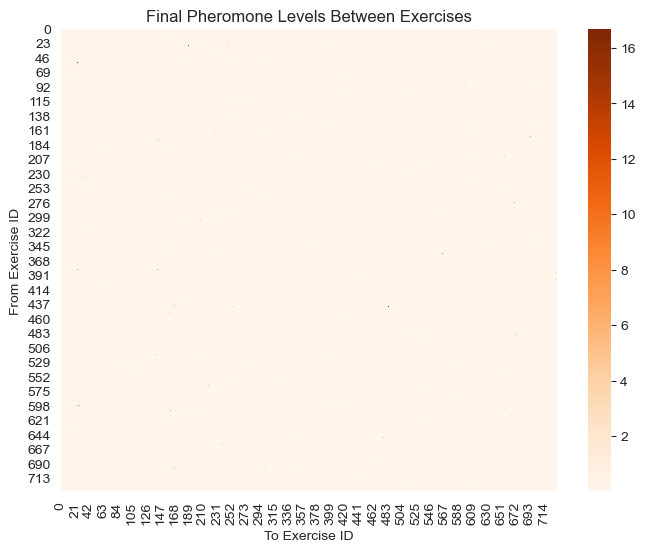

In [257]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style('darkgrid')

# Final pheromone matrix
pheromones = np.array(problem.pheromone_history[-1])
plt.figure(figsize=(8, 6))
sns.heatmap(pheromones, cmap='Oranges')
plt.title("Final Pheromone Levels Between Exercises")
plt.xlabel("To Exercise ID")
plt.ylabel("From Exercise ID")
plt.show()

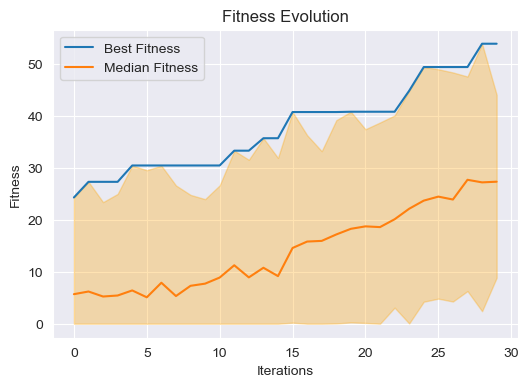

In [258]:
fitness = np.array([[ant[1] for ant in trails] for trails in problem.trails_history])
best_fitness = np.array(problem.best_fitness_history)

fig, axs = plt.subplots(figsize=(6, 4))
axs.set_title('Fitness Evolution')
axs.set_xlabel('Iterations')
axs.set_ylabel('Fitness')

axs.plot(best_fitness, label='Best Fitness')

median = np.median(fitness, axis=1)
min_ = np.min(fitness, axis=1)
max_ = np.max(fitness, axis=1)

axs.plot(median, label='Median Fitness')
axs.fill_between(np.arange(len(median)), min_, max_, alpha=0.3, color='orange')

axs.legend()
plt.show()

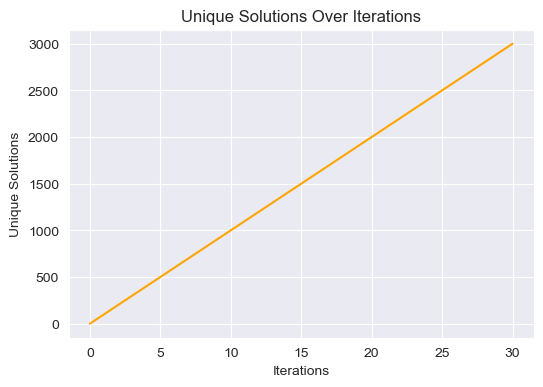

In [259]:
from itertools import accumulate
from typing import List

# Population per iteration
population = np.array([[np.array(ant[0]) for ant in trails] for trails in problem.trails_history])

def stringify_individual(individual: List[int]) -> str:
    return ''.join([str(int(i)) for i in individual])

# Convert and accumulate unique sets
a = np.apply_along_axis(stringify_individual, 2, population)
a = list(accumulate(a, lambda x, y: x.union(set(y)), initial=set()))

fig, axs = plt.subplots(figsize=(6, 4))
axs.plot([len(x) for x in a], color='orange')
axs.set_title('Unique Solutions Over Iterations')
axs.set_xlabel('Iterations')
axs.set_ylabel('Unique Solutions')
plt.show()